# Electricity Price Forecasting on the German day-ahead market

This notebook is the main interface to the associated EPF library. Various parameters can be adjusted within the library via the Config file. A more detailed description of the individual parameters can be found within the configuration classes. In the “exploratory_analysis” notebook, the raw data sets are analyzed exploratively and the results are displayed visually. Based on these results, features from the data sets were specifically selected for further use in the deep learning pipeline.

The forecasting pipeline is built to automatically perform data preprocessing including data cleaning, outlier removal and seasonal decomposition. Within the configuration feature engineering can be toggled on and of for each feature. Forecasting is done with three different models, that can be retrained and saved anytime. The models available are an LSTM, GRU and CNN. They all perform multi-step ahead, single shot forecasts. This means by default each forecast contains 24 time steps into the future, that are forecasted together in one computation.

In [1]:
from epf.pipeline import EpfPipeline

pipeline = EpfPipeline()

2025-05-08 15:27:55.726 | INFO     | epf.config:<module>:18 - PROJ_ROOT path is: C:\Users\valen\PycharmProjects\epf
2025-05-08 15:27:55.728 | INFO     | epf.config:create_dir:14 - DATA_DIR path is: C:/Users/valen/PycharmProjects/epf/data
2025-05-08 15:27:55.729 | INFO     | epf.config:create_dir:14 - RAW_DATA_DIR path is: C:/Users/valen/PycharmProjects/epf/data/raw
2025-05-08 15:27:55.729 | INFO     | epf.config:create_dir:14 - INTERIM_DATA_DIR path is: C:/Users/valen/PycharmProjects/epf/data/interim
2025-05-08 15:27:55.729 | INFO     | epf.config:create_dir:14 - PROCESSED_DATA_DIR path is: C:/Users/valen/PycharmProjects/epf/data/processed
2025-05-08 15:27:55.730 | INFO     | epf.config:create_dir:14 - TRAIN_DATA_DIR path is: C:/Users/valen/PycharmProjects/epf/data/processed/train_data
2025-05-08 15:27:55.731 | INFO     | epf.config:create_dir:14 - MODELS_DIR path is: C:/Users/valen/PycharmProjects/epf/models
2025-05-08 15:27:55.732 | INFO     | epf.config:create_dir:14 - PREDICTIONS_D

In [2]:
pipeline.train('lstm_all_features', overwrite=True, prep_data=False, use_tuned_hyperparams=True)

2025-05-08 15:27:58.984 | INFO     | epf.pipeline:train:334 - Data paths for training loop successfully initialized.
Model output: C:/Users/valen/PycharmProjects/epf/models/lstm_all_features.pkl.
Tuned model path: C:/Users/valen/PycharmProjects/epf/models/tuner/lstm_all_features.pkl.
Tuned Hyperparameters path: C:/Users/valen/PycharmProjects/epf/models/tuner/lstm_all_features_hyperparameters.pkl.

2025-05-08 15:27:59.185 | INFO     | epf.pipeline:train:370 - Now loading training data from disk.
2025-05-08 15:27:59.186 | SUCCESS  | epf.pipeline:train:374 - Successfully loaded training data for lstm_all_features
2025-05-08 15:27:59.186 | INFO     | epf.pipeline:train:389 - Skipping hyperparameter tuning and loading tuned hyperparameters for lstm_all_features from C:/Users/valen/PycharmProjects/epf/models/lstm_all_features.pkl.
2025-05-08 15:27:59.187 | INFO     | epf.pipeline:train:415 - Training lstm_all_features on the following Features:['DE-LU Prices', 'CH Prices', 'DK1 Prices', 'DK2

Epoch 1/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0227 - mean_absolute_error: 0.1110 - val_loss: 0.7263 - val_mean_absolute_error: 0.6427
Epoch 2/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0236 - mean_absolute_error: 0.1131 - val_loss: 0.6810 - val_mean_absolute_error: 0.6172
Epoch 3/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0219 - mean_absolute_error: 0.1088 - val_loss: 0.7484 - val_mean_absolute_error: 0.6487
Epoch 4/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0212 - mean_absolute_error: 0.1071 - val_loss: 0.7087 - val_mean_absolute_error: 0.6285


2025-05-08 15:28:25.174 | SUCCESS  | epf.pipeline:train:421 - Successfully trained lstm_all_features. Now saving...
2025-05-08 15:28:25.248 | SUCCESS  | epf.pipeline:train:444 - Successfully saved lstm_all_features to C:/Users/valen/PycharmProjects/epf/models/lstm_all_features.pkl


In [3]:
pipeline.evaluate('lstm_all_features')

2025-05-08 15:28:29.146 | INFO     | epf.pipeline:evaluate:455 - Loading trained model from C:\Users\valen\PycharmProjects\epf\models\lstm_all_features.pkl.


109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7062 - mean_absolute_error: 0.6305


In [ ]:
import pickle as pkl

with open("../data/processed/performance.pkl", "rb") as f:
    performance = pkl.load(f)

with open("../data/processed/val_performance.pkl", "rb") as f:
    val_performance = pkl.load(f)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

2025-05-08 15:32:07.310 | INFO     | epf.config:<module>:18 - PROJ_ROOT path is: C:\Users\valen\PycharmProjects\epf
2025-05-08 15:32:07.312 | INFO     | epf.config:create_dir:14 - DATA_DIR path is: C:/Users/valen/PycharmProjects/epf/data
2025-05-08 15:32:07.312 | INFO     | epf.config:create_dir:14 - RAW_DATA_DIR path is: C:/Users/valen/PycharmProjects/epf/data/raw
2025-05-08 15:32:07.313 | INFO     | epf.config:create_dir:14 - INTERIM_DATA_DIR path is: C:/Users/valen/PycharmProjects/epf/data/interim
2025-05-08 15:32:07.313 | INFO     | epf.config:create_dir:14 - PROCESSED_DATA_DIR path is: C:/Users/valen/PycharmProjects/epf/data/processed
2025-05-08 15:32:07.314 | INFO     | epf.config:create_dir:14 - TRAIN_DATA_DIR path is: C:/Users/valen/PycharmProjects/epf/data/processed/train_data
2025-05-08 15:32:07.315 | INFO     | epf.config:create_dir:14 - MODELS_DIR path is: C:/Users/valen/PycharmProjects/epf/models
2025-05-08 15:32:07.315 | INFO     | epf.config:create_dir:14 - PREDICTIONS_D

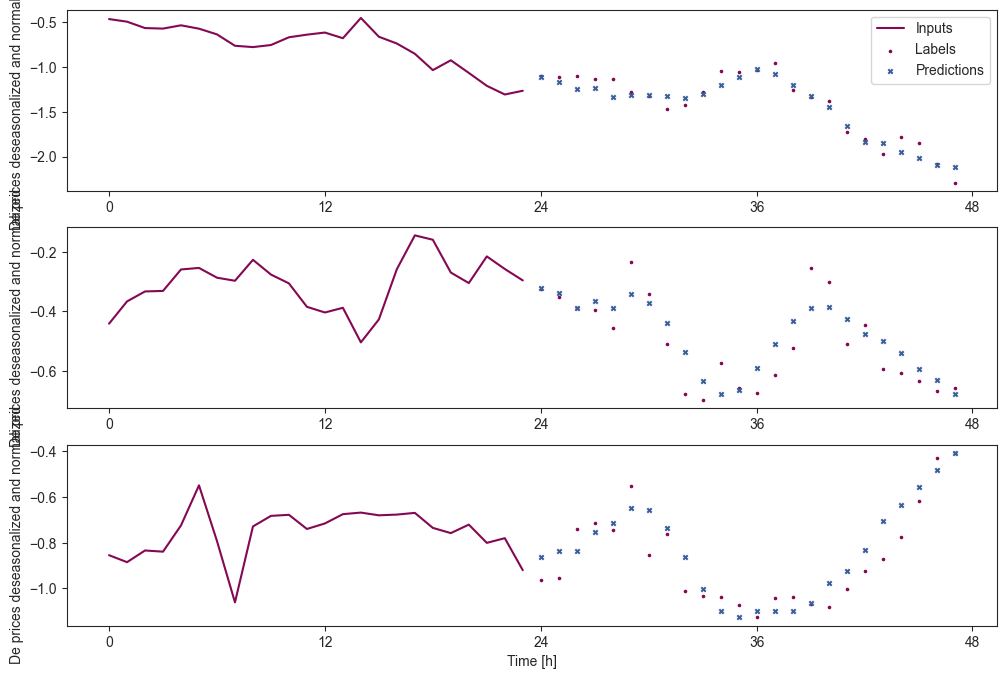

In [1]:
import pickle as pkl

with open("../models/lstm_all_features.pkl", "rb") as f:
    model_obj = pkl.load(f)

window = model_obj['window']
model = model_obj['best_model']
window.plot(model)

In [ ]:
from epf.config import PREDICTIONS_DIR, MODELS_DIR

model_path = MODELS_DIR / "lstm_all_features.keras"
predictions_dir = PREDICTIONS_DIR

In [ ]:
pipeline.predict(data=window.test, model_path=model_path, predictions_dir=predictions_dir)